*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [0]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.3
IPython 5.5.0

torch 0.4.1


- Runs on CPU or GPU (if available)

# Model Zoo -- Cyclical Learning Rate in PyTorch

This notebook will go over the following topics in the order listed below:

1. Briefly explain the concept behind the cyclical learning rate
2. Use the "LR range test" to choose a good base and max learning rate for the cyclical leraning rate
3. Train a simple convolutional neural net on CIFAR-10 using the cyclical learning rate

## Cyclical Learning Rate Concept

In his paper [1], Leslie N. Smith introduced the concept of cyclical learning rates, that is, learning rates that periodically alternative between a user-specified minimum and maximum learning rate. 

Varying the learning rate between between specified bounds, as implemented by Smith, is cheaper to compute than the nowadays popular approach using adaptive learning rates. Note that adaptive learning rate can also be combined with the concept of cyclical learning rates.

The idea behind cyclical learning rates is that while increasing the learning rate can be harmful short term it can be beneficial in the long run. Concretely, the three methods introduced by Smith (and implemented in this notebook) are

- `triangular`: The base approach, varying between a lower and an upper bound, as illustrated in the figure below
- `triangular2`: Same as triangular, but learning rate difference is cut in half at the end of each cycle. This means the learning rate difference drops after each cycle
-- `exp_range`: The learning rate varies between the minimum and maximum boundaries and each boundary value declines by an exponential factor of $gamma^{iteration}$


{insert figure}


### References


- [1] Smith, Leslie N. “[Cyclical learning rates for training neural networks](https://ieeexplore.ieee.org/abstract/document/7926641/).” Applications of Computer Vision (WACV), 2017 IEEE Winter Conference on. IEEE, 2017.

Following the description in the paper, the different cyclical learning rates are very simple to implement, as shown below:

In [0]:
import numpy as np


def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.001,
                           max_lr=0.006,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr

To ensure that the learning rate works as intended, let us plot the learning rate variation for a dry run. Note that `batch_step` is a variable that tracks the total number of times a model has been updated. For instance, if we run the training loop over 5 epochs (5 passes over the training set), where each epoch is split into 100 batches, then we have a `batch_step` count of 5 * 100 = 500 at the end of the training. 

In [0]:
num_epochs = 50
num_train = 50000
batch_size = 100
iter_per_ep = num_train // batch_size

**Triangular**

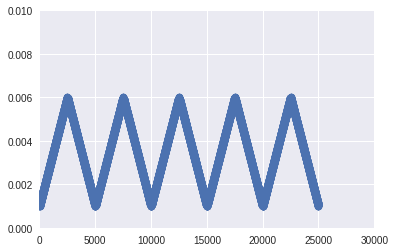

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*5)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

As we can see above, with a batchsize of 100 and for a training set of 50,000 training example, we have 50,000=500 iterations per epoch. With a cycle length of 5*iterations_per_epoch=25,000, the learning rate reaches the base_lr every 5 epochs, which is equal to 25,000 batch updates. The stepsize is defined as cycle/2, i.e., 25,000/2 = 12,500 batch updates.

**Triangular2**

The `triangular2` learning rate is similar to the `triangular` learning rate but cuts the max. learning rate in halve after each cycle.

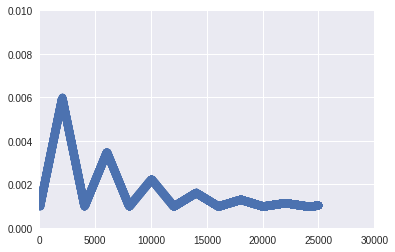

In [0]:
collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='triangular2')
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

**Exp_range**

The `exp_range` option adds an additional hyperparameter, `gamma` to decay the learning rate exponentially.

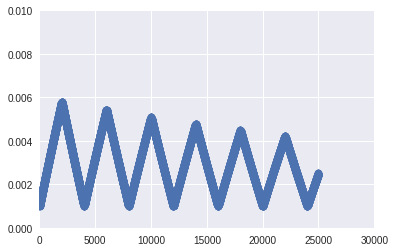

In [0]:
collect_lr = []
batch_step = -1
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=iter_per_ep*4,
                                        mode='exp_range',
                                        gamma=0.99998)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

## Torch Imports

In [0]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

## Settings and Dataset

In [0]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
batch_size = 128

# Architecture
num_classes = 10


##########################
### CIFAR-10 DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range

## Create a validation dataset
np.random.seed(random_seed)
idx = np.arange(50000) # the size of CIFAR10-train
np.random.shuffle(idx)
val_idx, train_idx = idx[:1000], idx[1000:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          # shuffle=True, # Subsetsampler already shuffles
                          sampler=train_sampler)

val_loader = DataLoader(dataset=train_dataset, 
                        batch_size=batch_size, 
                        # shuffle=True,
                        sampler=val_sampler)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
cnt = 0
for images, labels in train_loader: 
    cnt += images.shape[0]
print('Number of training examples:', cnt)

cnt = 0
for images, labels in val_loader: 
    cnt += images.shape[0]
print('Number of validation instances:', cnt)

cnt = 0
for images, labels in test_loader: 
    cnt += images.shape[0]
print('Number of test instances:', cnt)

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Number of training examples: 49000
Number of validation instances: 1000
Number of test instances: 10000


## Model

Note that this is a very simple convolutional network in this notebook, which is not geared to reach best performance on CIFAR-10 but rather to test the implementation of the cyclical learning rate concept.

In [0]:
##########################
### MODEL
##########################


class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 32x32x3 => 32x32x6
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=6,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(32-1) - 32 + 3) / 2) = 1
        # 32x32x4 => 16x16x6
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(16-1) - 32 + 2) = 0                                       
        
        
        # 16x16x6 => 16x16x12
        self.conv_2 = torch.nn.Conv2d(in_channels=6,
                                      out_channels=12,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(16-1) - 16 + 3) / 2 = 1                 
        # 16x16x12 => 8x8x12                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(8-1) - 16 + 2) = 0
        
        
        # 8x8x12 => 8x8x18
        self.conv_3 = torch.nn.Conv2d(in_channels=12,
                                      out_channels=18,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) # (1(8-1) - 8 + 3) / 2 = 1                 
        # 8x8x18 => 4x4x18                             
        self.pool_3 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(4-1) - 8 + 2) = 0
        
        
        # 4x4x18 => 4x4x24
        self.conv_4 = torch.nn.Conv2d(in_channels=18,
                                      out_channels=24,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                 
        # 4x4x24 => 2x2x24                             
        self.pool_4 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)
        
        
        # 2x2x24 => 2x2x30
        self.conv_5 = torch.nn.Conv2d(in_channels=24,
                                      out_channels=30,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)                 
        # 2x2x30 => 1x1x30                             
        self.pool_5 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)
        
        self.linear_1 = torch.nn.Linear(1*1*30, num_classes)

        
    def forward(self, x):
        out = self.conv_1(x)
        out = F.relu(out)
        out = self.pool_1(out)

        out = self.conv_2(out)
        out = F.relu(out)
        out = self.pool_2(out)
        
        out = self.conv_3(out)
        out = F.relu(out)
        out = self.pool_3(out)
        
        out = self.conv_4(out)
        out = F.relu(out)
        out = self.pool_4(out)
        
        out = self.conv_5(out)
        out = F.relu(out)
        out = self.pool_5(out)
        
        logits = self.linear_1(out.view(-1, 1*1*30))
        probas = F.softmax(logits, dim=1)
        return logits, probas

## LR Range Test

The LR range test is a simple heuristic that is also described in Smith's paper. Essentially, it's a quick-and-dirty approach to find good values for the `base_lr` and `max_lr` (hyperparameters of the cyclical learning rate).

It works as follows:

We run the training for 5-10 epochs and increase the learning rate linearly up to an upper bound. We select the cut-off where the (train or validation) accuracy starts improving as the base_lr for the cyclical learning rate. The max_lr for the cyclical learning rate is determined in a similar manner, by choosing the cut-off value where the accuracy improvements stop, decrease, or widely fluctuate.

Note that we can use the `cyclical_learning_rate` function to compute the learning rates for the increasing interval by setting `step_size=num_epochs*iter_per_ep`:

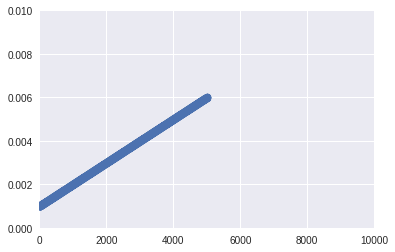

In [0]:
num_epochs = 10

batch_step = -1
collect_lr = []
for e in range(num_epochs):
    for i in range(iter_per_ep):
        batch_step += 1
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=num_epochs*iter_per_ep)
        
        collect_lr.append(cur_lr)
        
plt.scatter(range(len(collect_lr)), collect_lr)
plt.ylim([0.0, 0.01])
plt.xlim([0, num_epochs*iter_per_ep + 5000])
plt.show()

**Utility Functions**

In [0]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

**Train Model/Run LR Range Test**

In [0]:
#################################
### Setting for this run
#################################

num_epochs = 10
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.01
max_lr = 0.2

#################################
### Init Model
#################################

torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'lr': [], 'cost': [], 'train_batch_acc': [], 'val_acc': []}
########################################################################


batch_step = -1
cur_lr = base_lr
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        batch_step += 1
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #############################################
        # Logging
        if not batch_step % 200:
            print('Total batch # %5d/%d' % (batch_step, 
                                            iter_per_ep*num_epochs), 
                  end='')
            print('   Curr. Batch Cost: %.5f' % cost)     

        #############################################
        # Collect stats    
        model = model.eval()
        train_acc = compute_accuracy(model, [[features, targets]])
        val_acc = compute_accuracy(model, val_loader)
        collect['lr'].append(cur_lr)
        collect['train_batch_acc'].append(train_acc)
        collect['val_acc'].append(val_acc)
        collect['cost'].append(cost)
        model = model.train()
        #############################################
        # update learning rate
        cur_lr = cyclical_learning_rate(batch_step=batch_step,
                                        step_size=num_epochs*iter_per_ep,
                                        base_lr=base_lr,
                                        max_lr=max_lr)
        for g in optimizer.param_groups:
            g['lr'] = cur_lr
        ############################################

Total batch #     0/3820   Curr. Batch Cost: 2.31266
Total batch #   200/3820   Curr. Batch Cost: 2.30711
Total batch #   400/3820   Curr. Batch Cost: 2.30392
Total batch #   600/3820   Curr. Batch Cost: 2.30356
Total batch #   800/3820   Curr. Batch Cost: 2.30203
Total batch #  1000/3820   Curr. Batch Cost: 2.30223
Total batch #  1200/3820   Curr. Batch Cost: 2.30101
Total batch #  1400/3820   Curr. Batch Cost: 2.30153
Total batch #  1600/3820   Curr. Batch Cost: 2.25885
Total batch #  1800/3820   Curr. Batch Cost: 2.17799
Total batch #  2000/3820   Curr. Batch Cost: 2.01709
Total batch #  2200/3820   Curr. Batch Cost: 1.94690
Total batch #  2400/3820   Curr. Batch Cost: 1.63447
Total batch #  2600/3820   Curr. Batch Cost: 1.73498
Total batch #  2800/3820   Curr. Batch Cost: 1.50548
Total batch #  3000/3820   Curr. Batch Cost: 1.58736
Total batch #  3200/3820   Curr. Batch Cost: 1.40857
Total batch #  3400/3820   Curr. Batch Cost: 1.59693
Total batch #  3600/3820   Curr. Batch Cost: 1

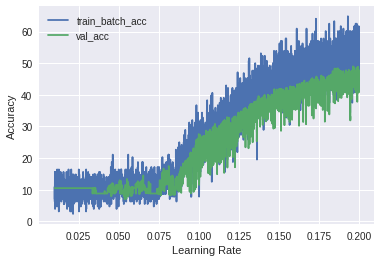

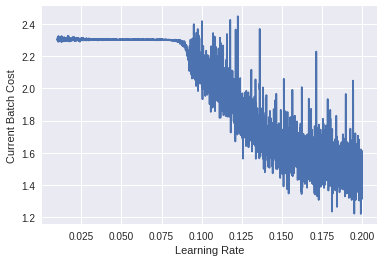

In [0]:
plt.plot(collect['lr'], collect['train_batch_acc'], label='train_batch_acc')
plt.plot(collect['lr'], collect['val_acc'], label='val_acc')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['lr'], collect['cost'])
plt.xlabel('Learning Rate')
plt.ylabel('Current Batch Cost')
plt.show()

Looking at the graphs above, in particular the validation accuracy, it's not immediately obvious to find the 2 points:

1. Where the accuracy starts increasing
2. Where the accuracy starts dropping or ceases to improve

However, point 1) may be at 0.08-0.09, and point 2) may be at 0.175 or even 0.2 (or even beyond that, if we would keep increasing the learning rate).


Also note that this heuristic is less "clean" as starting the epoch from scratch with each incremental learning rate change, which adds addtional noise to the interpretation (including questions like "by how much did the cost drop/accuracy improve just because of going downhill on the cost surface and the gradients becoming smaller?")

## Train with Cyclical Learning Rate (`triangular`)

Below, the triangular (default) cyclical learning rate training procedure is run with a `base_lr=0.09` and `max_lr=0.175`. Based on the LR Range Tests graphs above, a `max_lr` >= 0.2 may even be reasonable. However, in practice (based on my experience and some trial runs with these settings), such large learning rates would increase  convergence problems using a vanilla SGD optimizer (as it is done here). 

In [0]:
#################################
### Setting for this run
#################################

num_epochs = 150
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.09
max_lr = 0.175

#################################
### Init Model
#################################

torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'epoch': [], 'cost': [], 'train_acc': [], 'val_acc': []}
########################################################################


for epoch in range(num_epochs):
    epoch_avg_cost = 0.
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        epoch_avg_cost += cost
        
        #############################################
        # Logging
        if not batch_step % 600:
            print('Batch %5d/%d' % (batch_step, iter_per_ep*num_epochs),
                                    end='')
            print('   Cost: %.5f' % cost)     


    #############################################
    # Collect stats    
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    epoch_avg_cost /= batch_idx+1
    collect['epoch'].append(epoch+1)
    collect['val_acc'].append(val_acc)
    collect['train_acc'].append(train_acc)
    collect['cost'].append(epoch_avg_cost / iter_per_ep)
    
    ################################################
    # Logging
    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))
    
    
    #############################################
    # update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=num_epochs*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr)
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    ############################################

Epoch   1  |  Train/Valid Acc: 10.09/11.50
Epoch   2  |  Train/Valid Acc: 11.58/11.80
Epoch   3  |  Train/Valid Acc: 25.46/23.40
Epoch   4  |  Train/Valid Acc: 23.22/25.00
Epoch   5  |  Train/Valid Acc: 38.93/38.00
Epoch   6  |  Train/Valid Acc: 41.49/40.00
Epoch   7  |  Train/Valid Acc: 39.71/35.80
Epoch   8  |  Train/Valid Acc: 44.34/42.80
Epoch   9  |  Train/Valid Acc: 50.06/49.60
Epoch  10  |  Train/Valid Acc: 50.94/49.60
Epoch  11  |  Train/Valid Acc: 52.94/52.30
Epoch  12  |  Train/Valid Acc: 52.46/51.70
Epoch  13  |  Train/Valid Acc: 53.39/53.40
Epoch  14  |  Train/Valid Acc: 53.25/50.30
Epoch  15  |  Train/Valid Acc: 56.96/54.60
Epoch  16  |  Train/Valid Acc: 54.70/52.10
Epoch  17  |  Train/Valid Acc: 56.33/52.30
Epoch  18  |  Train/Valid Acc: 56.30/52.40
Epoch  19  |  Train/Valid Acc: 59.31/55.60
Epoch  20  |  Train/Valid Acc: 58.30/54.00
Epoch  21  |  Train/Valid Acc: 60.80/57.20
Epoch  22  |  Train/Valid Acc: 58.80/56.30
Epoch  23  |  Train/Valid Acc: 62.28/56.30
Epoch  24  

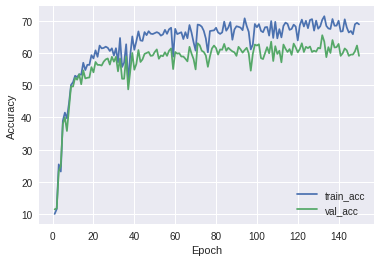

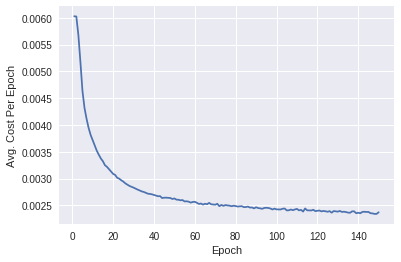

In [0]:
plt.plot(collect['epoch'], collect['train_acc'], label='train_acc')
plt.plot(collect['epoch'], collect['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], collect['cost'])
plt.xlabel('Epoch')
plt.ylabel('Avg. Cost Per Epoch')
plt.show()

In [0]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 60.74%


## Train with Cyclical Learning Rate (`triangular2`)

Epoch   1  |  Train/Valid Acc: 10.09/11.50
Epoch   2  |  Train/Valid Acc: 11.57/11.90
Epoch   3  |  Train/Valid Acc: 25.86/23.90
Epoch   4  |  Train/Valid Acc: 27.48/29.40
Epoch   5  |  Train/Valid Acc: 39.77/39.00
Epoch   6  |  Train/Valid Acc: 40.88/37.90
Epoch   7  |  Train/Valid Acc: 39.27/35.90
Epoch   8  |  Train/Valid Acc: 45.63/42.90
Epoch   9  |  Train/Valid Acc: 49.74/48.20
Epoch  10  |  Train/Valid Acc: 49.91/48.20
Epoch  11  |  Train/Valid Acc: 52.43/49.60
Epoch  12  |  Train/Valid Acc: 51.98/49.30
Epoch  13  |  Train/Valid Acc: 55.04/53.10
Epoch  14  |  Train/Valid Acc: 51.02/49.50
Epoch  15  |  Train/Valid Acc: 56.82/53.80
Epoch  16  |  Train/Valid Acc: 58.95/54.50
Epoch  17  |  Train/Valid Acc: 55.30/53.70
Epoch  18  |  Train/Valid Acc: 59.15/53.90
Epoch  19  |  Train/Valid Acc: 60.19/58.10
Epoch  20  |  Train/Valid Acc: 61.53/58.10
Epoch  21  |  Train/Valid Acc: 58.87/54.90
Epoch  22  |  Train/Valid Acc: 56.68/53.70
Epoch  23  |  Train/Valid Acc: 61.61/58.70
Epoch  24  

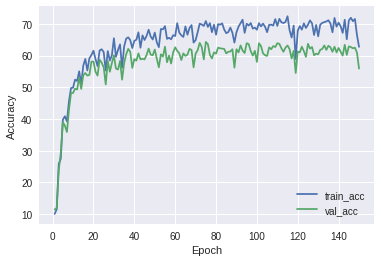

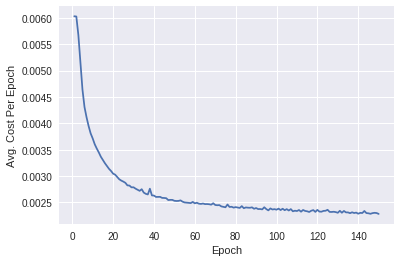

In [0]:
#################################
### Setting for this run
#################################

num_epochs = 150
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.09
max_lr = 0.175

#################################
### Init Model
#################################

torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'epoch': [], 'cost': [], 'train_acc': [], 'val_acc': []}
########################################################################


for epoch in range(num_epochs):
    epoch_avg_cost = 0.
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        epoch_avg_cost += cost
        
        #############################################
        # Logging
        if not batch_step % 600:
            print('Batch %5d/%d' % (batch_step, iter_per_ep*num_epochs),
                                    end='')
            print('   Cost: %.5f' % cost)     


    #############################################
    # Collect stats    
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    epoch_avg_cost /= batch_idx+1
    collect['epoch'].append(epoch+1)
    collect['val_acc'].append(val_acc)
    collect['train_acc'].append(train_acc)
    collect['cost'].append(epoch_avg_cost / iter_per_ep)
    
    ################################################
    # Logging
    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))
    
    
    #############################################
    # update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=num_epochs*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr,
                                     mode='triangular2')
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    ############################################
    
    
plt.plot(collect['epoch'], collect['train_acc'], label='train_acc')
plt.plot(collect['epoch'], collect['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], collect['cost'])
plt.xlabel('Epoch')
plt.ylabel('Avg. Cost Per Epoch')
plt.show()

In [0]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 55.97%


## Train with Cyclical Learning Rate (`exp_range`)

Epoch   1  |  Train/Valid Acc: 10.13/11.60
Epoch   2  |  Train/Valid Acc: 11.55/11.70
Epoch   3  |  Train/Valid Acc: 25.75/23.20
Epoch   4  |  Train/Valid Acc: 27.51/29.00
Epoch   5  |  Train/Valid Acc: 39.12/38.30
Epoch   6  |  Train/Valid Acc: 41.39/39.90
Epoch   7  |  Train/Valid Acc: 39.65/36.20
Epoch   8  |  Train/Valid Acc: 44.70/43.00
Epoch   9  |  Train/Valid Acc: 50.36/47.70
Epoch  10  |  Train/Valid Acc: 48.98/46.90
Epoch  11  |  Train/Valid Acc: 52.94/50.90
Epoch  12  |  Train/Valid Acc: 53.53/51.90
Epoch  13  |  Train/Valid Acc: 54.76/51.70
Epoch  14  |  Train/Valid Acc: 53.30/51.10
Epoch  15  |  Train/Valid Acc: 53.76/52.00
Epoch  16  |  Train/Valid Acc: 54.93/53.40
Epoch  17  |  Train/Valid Acc: 55.76/53.70
Epoch  18  |  Train/Valid Acc: 57.37/53.40
Epoch  19  |  Train/Valid Acc: 59.95/57.10
Epoch  20  |  Train/Valid Acc: 59.25/56.00
Epoch  21  |  Train/Valid Acc: 60.19/56.50
Epoch  22  |  Train/Valid Acc: 61.81/59.10
Epoch  23  |  Train/Valid Acc: 61.85/59.10
Epoch  24  

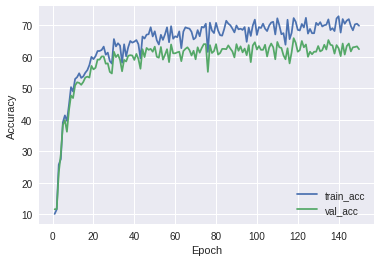

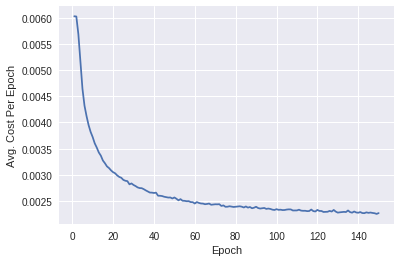

In [0]:
#################################
### Setting for this run
#################################

num_epochs = 150
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.09
max_lr = 0.175

#################################
### Init Model
#################################

torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'epoch': [], 'cost': [], 'train_acc': [], 'val_acc': []}
########################################################################


for epoch in range(num_epochs):
    epoch_avg_cost = 0.
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        epoch_avg_cost += cost
        
        #############################################
        # Logging
        if not batch_step % 600:
            print('Batch %5d/%d' % (batch_step, iter_per_ep*num_epochs),
                                    end='')
            print('   Cost: %.5f' % cost)     


    #############################################
    # Collect stats    
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    epoch_avg_cost /= batch_idx+1
    collect['epoch'].append(epoch+1)
    collect['val_acc'].append(val_acc)
    collect['train_acc'].append(train_acc)
    collect['cost'].append(epoch_avg_cost / iter_per_ep)
    
    ################################################
    # Logging
    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))
    
    
    #############################################
    # update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=num_epochs*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr,
                                     mode='exp_range')
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    ############################################
    
    
plt.plot(collect['epoch'], collect['train_acc'], label='train_acc')
plt.plot(collect['epoch'], collect['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], collect['cost'])
plt.xlabel('Epoch')
plt.ylabel('Avg. Cost Per Epoch')
plt.show()

In [0]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 61.91%
